# Imports

In [ ]:
import os
import torch
import torch
from torch import nn
from torchvision import datasets
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import psutil
import h5py
import os
import numpy as np
import time
import copy
from torchsummary import summary
from torch import optim
from torch.optim import lr_scheduler
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

!pip install vit-pytorch
!pip install torchviz

from vit_pytorch import ViT
from torchviz import make_dot


try:
  import google.colab
  COLAB_ENV = True
except:
  COLAB_ENV = False

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 68 kB 3.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4150 sha256=fa89265e902928b41d26485c3002724c04d7c8db7b3d85db76a5e4dbf6a9150d
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


In [ ]:
class MaxoutMLP(torch.nn.Module):
    """
        Maxout using Multilayer Perceptron
    """
    def __init__(self, input_size, linear_layers, linear_neurons):
        """

        :param input_size: number of values (pixels or hidden unit's output_ that
                            will be inputted to the layer
        :param linear_layers:  number of linear layers before max operation
        :param linear_neurons: number of nerons in each linear layer before max operation
        """
        super(MaxoutMLP, self).__init__()

        # initialize variables
        self.input_size = input_size
        self.linear_layers = linear_layers
        self.linear_neurons = linear_neurons

        # batch normalization layer
        self.BN = torch.nn.BatchNorm1d(self.linear_neurons)

        # pytorch not able to reach the parameters of linear layer inside
        # a list
        self.params = torch.nn.ParameterList()
        self.z = []

        for layer in range(self.linear_layers):
            self.z.append(torch.nn.Linear(self.input_size, self.linear_neurons))
            self.params.extend(list(self.z[layer].parameters()))

    def forward(self, input_, is_norm=False, **kwargs):
        """

        :param input_: input to maxout layer
        :param is_norm:whether to perform normalization before max operation
        :param kwargs:
        :return:
        """
        h = None
        for layer in range(self.linear_layers):
            z = self.z[layer](input_)

            # norm + norm constraint
            if is_norm:
                z =self.BN(z)

            if layer == 0:
                h = z
            else:
                h = torch.max(h, z)
        return h

  
class MaxoutConv(torch.nn.Module):
    """Maxout layer with convolution"""

    def __init__(self, in_channels,
                 out_channels, kernel_size, padding):
        """
        Define layers of maxout unit
        :param in_channels: number of channel of input convolution
        :type in_channels: :py:obj:`int`
        :param out_channels: number of channel of output convolution
        :type out_channels: :py:obj:`int`
        :param kernel_size: size of the weight matrix to convolve
        :type kernel_size: (:py:obj:`int`, :py:obj:`int`)
        """
        super(MaxoutConv, self).__init__()

        self.conv = torch.nn.Conv2d(in_channels, out_channels, kernel_size,
                                    padding=padding)

        self.BN = torch.nn.BatchNorm2d(out_channels)

    def forward(self, _input, is_norm=False):
        """
        Pass the input to the maxout layer
        :param _input: input to the maxout layer
                       input is expected to have channel dimension
        :type _input: :py:class:`torch.Tensor`
        """
        z = self.conv(_input)
        if is_norm:
            z = self.BN(z)
        # (batch size, channels, height, width)
        h = torch.max(z, 1).values     # take max operation from first dimension(channel)
        # Insert 1 as channel dimension to h
        hshape = h.shape
        h = h.reshape(*([hshape[0]] + [1] + list(hshape[1:])))
        return h


# Data Loading

In [ ]:
if COLAB_ENV:
  start = "/" + os.path.join("content","drive","MyDrive","datasets")
  from google.colab import drive
  drive.mount('/content/drive')
else:
  start = "data"

Mounted at /content/drive


In [ ]:
data_filepath = os.path.join(start, "CERN", "ParticleClassification")
photon_file = "SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5"
electron_file = "SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5"

photon_filepath = os.path.join(data_filepath, photon_file)
electron_filepath = os.path.join(data_filepath, electron_file)

electronFile = h5py.File(electron_filepath, "r")
photonFile = h5py.File(photon_filepath, "r")

class PhotonElectronDataset(Dataset):
    def __init__(self, _electron_filepath, _photon_filepath, transform=None, target_transform=None, low = 0, high = 1):
        global seed
        np.random.seed(seed)

        electronFile = h5py.File(_electron_filepath, "r")
        photonFile = h5py.File(_photon_filepath, "r")

        ElectronX, ElectronY = electronFile["X"], electronFile["y"]
        PhotonX, PhotonY = photonFile["X"], photonFile["y"]

        indexes = np.random.permutation(ElectronX.shape[0])

        _low = int(low * len(indexes))
        _high = int(high * len(indexes))

        self.X = np.concatenate([ElectronX[_low:_high, :,:,:], PhotonX[_low:_high, :,:,:]])
        self.Y = np.concatenate([ElectronY[_low:_high], PhotonY[_low:_high]])
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        #image = torch.from_numpy(self.X[idx, :, :, :])
        image = self.X[idx, :, :, :]

        label = self.Y[idx,]
        if self.transform:
            image = self.transform(image)
        return image, label


In [ ]:
seed = 42
train_test_split = 0.8

print(f"Before {psutil.virtual_memory()[1] / (1e9)}")
training_data = PhotonElectronDataset(electron_filepath, photon_filepath, transform=transforms.Compose([transforms.ToTensor()]), low=0, high=train_test_split)
validation_data = PhotonElectronDataset(electron_filepath, photon_filepath, transform=transforms.Compose([transforms.ToTensor()]), low=train_test_split, high=1)

print(f"Training dataset : {len(training_data)}")
print(f"Validation dataset : {len(validation_data)}")

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=64, shuffle=True)

print(f"After {psutil.virtual_memory()[1] / (1e9)}")

Before 87.950123008
Training dataset : 398400
Validation dataset : 99600
After 84.375400448


# Util functions

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Device Used : {device}")

def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, saveTo, num_epochs=25):
    since = time.time()

    returnDict = {"trainingLoss" : [], "validationLoss" : [], "trainingAccuracy" : [], "validationAccuracy" : [], 
                  "epochs" : [], "trainingAUC" : [], "validationAUC" : []}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        returnDict["epochs"].append(epoch)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            since2 = time.time()
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            y = torch.Tensor()
            pred_y = torch.Tensor()

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                labels = labels.long()

                y = torch.cat([y, labels.cpu()])
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    probs, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    pred_y = torch.cat([pred_y, outputs[:, 1].cpu()])

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            AUC_ROC = roc_auc_score(y.detach().numpy(), pred_y.detach().numpy())  

            if phase == "train":
                returnDict["trainingLoss"].append(epoch_loss)
                returnDict["trainingAccuracy"].append(epoch_acc.cpu().item())
                returnDict["trainingAUC"].append(AUC_ROC)
            else:
                returnDict["validationLoss"].append(epoch_loss)
                returnDict["validationAccuracy"].append(epoch_acc.cpu().item())
                returnDict["validationAUC"].append(AUC_ROC)
 
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} AUC ROC : {AUC_ROC:.4f} Time taken : {round(time.time() - since2, 2)}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model, saveTo)

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    returnDict["best_model"] = model
    return returnDict



Device Used : cuda:0


In [ ]:
def plotResults(results):
    plt.figure(figsize=(16,12))
    plt.subplot(3,1, 1)
    plt.plot(results['epochs'], results['trainingLoss'], label="training Loss")
    plt.plot(results['epochs'], results['validationLoss'], label="validation Loss")
    plt.legend()

    plt.subplot(3,1, 2)
    plt.plot(results['epochs'], results['trainingAccuracy'], label="training Accuracy")
    plt.plot(results['epochs'], results['validationAccuracy'], label="validation Accuracy")
    plt.legend()
  
  
    plt.subplot(3,1, 3)
    plt.plot(results['epochs'], results['trainingAUC'], label="training ROC")
    plt.plot(results['epochs'], results['validationAUC'], label="validation AUC ROC")
    plt.legend()

    plt.show()

# Anything Working

## Model definition

In [ ]:
class BasicNN(nn.Module):
    def __init__(self):
        super(BasicNN, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2* 32 * 32, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 2),
            nn.Softmax(1)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


model_ft = BasicNN()
model_ft = model_ft.to(device)

summary(model_ft, input_size=(32,32, 2))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 2048]               0
            Linear-2                  [-1, 256]         524,544
              ReLU-3                  [-1, 256]               0
            Linear-4                  [-1, 256]          65,792
              ReLU-5                  [-1, 256]               0
            Linear-6                    [-1, 2]             514
           Softmax-7                    [-1, 2]               0
Total params: 590,850
Trainable params: 590,850
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.02
Params size (MB): 2.25
Estimated Total Size (MB): 2.29
----------------------------------------------------------------


## Training

In [ ]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters())

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

results = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,{"train" : train_dataloader, "val": validation_dataloader},
                       {"train" : len(training_data), "val" : len(validation_data)}, saveTo="basicNN", num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6468 Acc: 0.6302 AUC ROC : 0.6713 Time taken : 26.41
val Loss: 0.6318 Acc: 0.6530 AUC ROC : 0.6994 Time taken : 3.78

Epoch 1/24
----------
train Loss: 0.6144 Acc: 0.6753 AUC ROC : 0.7259 Time taken : 24.13
val Loss: 0.6127 Acc: 0.6777 AUC ROC : 0.7283 Time taken : 3.86

Epoch 2/24
----------
train Loss: 0.5959 Acc: 0.6984 AUC ROC : 0.7508 Time taken : 24.49
val Loss: 0.6118 Acc: 0.6799 AUC ROC : 0.7310 Time taken : 3.78

Epoch 3/24
----------
train Loss: 0.5821 Acc: 0.7152 AUC ROC : 0.7672 Time taken : 24.14
val Loss: 0.6104 Acc: 0.6821 AUC ROC : 0.7316 Time taken : 3.79

Epoch 4/24
----------
train Loss: 0.5689 Acc: 0.7313 AUC ROC : 0.7814 Time taken : 24.05
val Loss: 0.6136 Acc: 0.6807 AUC ROC : 0.7286 Time taken : 3.78

Epoch 5/24
----------
train Loss: 0.5575 Acc: 0.7446 AUC ROC : 0.7928 Time taken : 23.96
val Loss: 0.6178 Acc: 0.6774 AUC ROC : 0.7244 Time taken : 4.09

Epoch 6/24
----------
train Loss: 0.5472 Acc: 0.7566 AUC ROC : 0.8022 Time t

## Plots

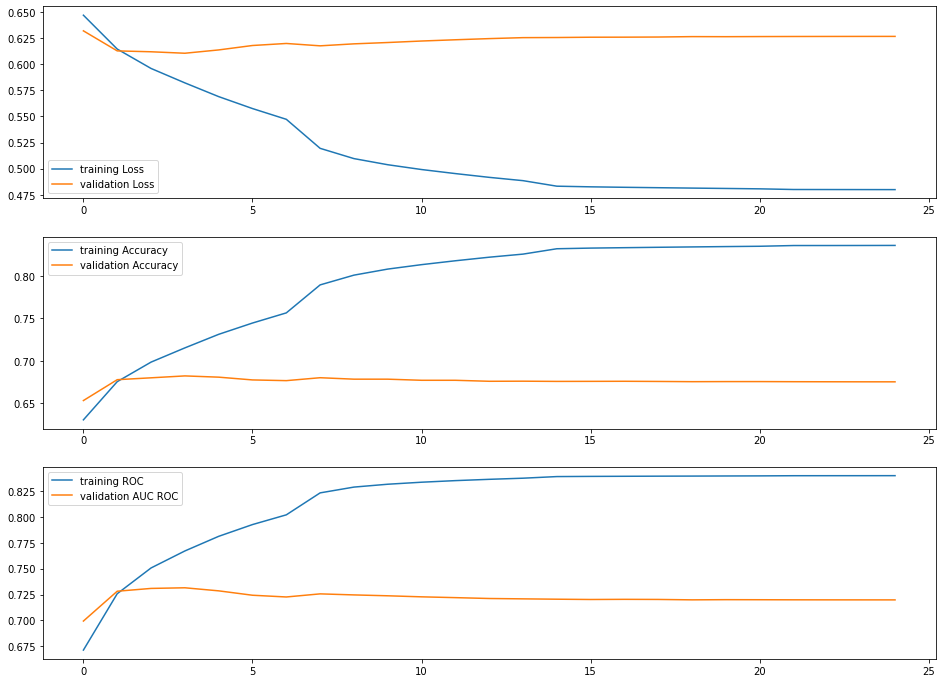

In [ ]:
plotResults(results)

# Maxout Conv

In [ ]:
class MLP_with_Maxout(nn.Module):
    def __init__(self):
        super(MLP_with_Maxout, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2 * 32 * 32, 256),
            MaxoutMLP(256, 5, 256),
            nn.Linear(256, 256),
            MaxoutMLP(256, 5, 128),
            nn.Linear(128, 2),
            nn.Softmax(1)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


model_ft = MLP_with_Maxout()
model_ft = model_ft.to(device)

summary(model_ft, input_size=(32, 32, 2))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 2048]               0
            Linear-2                  [-1, 256]         524,544
         MaxoutMLP-3                  [-1, 256]               0
            Linear-4                  [-1, 256]          65,792
         MaxoutMLP-5                  [-1, 128]               0
            Linear-6                    [-1, 2]             258
           Softmax-7                    [-1, 2]               0
Total params: 590,594
Trainable params: 590,594
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.02
Params size (MB): 2.25
Estimated Total Size (MB): 2.28
----------------------------------------------------------------


# Training

In [ ]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters())

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

results = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,{"train" : train_dataloader, "val": validation_dataloader},
                       {"train" : len(training_data), "val" : len(validation_data)}, saveTo="basicNN", num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6506 Acc: 0.6243 AUC ROC : 0.6542
val Loss: 0.6398 Acc: 0.6367 AUC ROC : 0.6701

Epoch 1/24
----------
train Loss: 0.6306 Acc: 0.6508 AUC ROC : 0.6834
val Loss: 0.6229 Acc: 0.6618 AUC ROC : 0.6975

Epoch 2/24
----------
train Loss: 0.6122 Acc: 0.6729 AUC ROC : 0.7057
val Loss: 0.6118 Acc: 0.6707 AUC ROC : 0.7008

Epoch 3/24
----------
train Loss: 0.5998 Acc: 0.6853 AUC ROC : 0.7173
val Loss: 0.6025 Acc: 0.6843 AUC ROC : 0.7073

Epoch 4/24
----------
train Loss: 0.5904 Acc: 0.6935 AUC ROC : 0.7231
val Loss: 0.5979 Acc: 0.6880 AUC ROC : 0.6863

Epoch 5/24
----------
train Loss: 0.5825 Acc: 0.7007 AUC ROC : 0.7281
val Loss: 0.5955 Acc: 0.6881 AUC ROC : 0.6980

Epoch 6/24
----------
train Loss: 0.5756 Acc: 0.7066 AUC ROC : 0.7319
val Loss: 0.5976 Acc: 0.6925 AUC ROC : 0.7262

Epoch 7/24
----------
train Loss: 0.5472 Acc: 0.7274 AUC ROC : 0.7702
val Loss: 0.5858 Acc: 0.7048 AUC ROC : 0.7414

Epoch 8/24
----------
train Loss: 0.5382 Acc: 0.7343 AUC ROC : 0

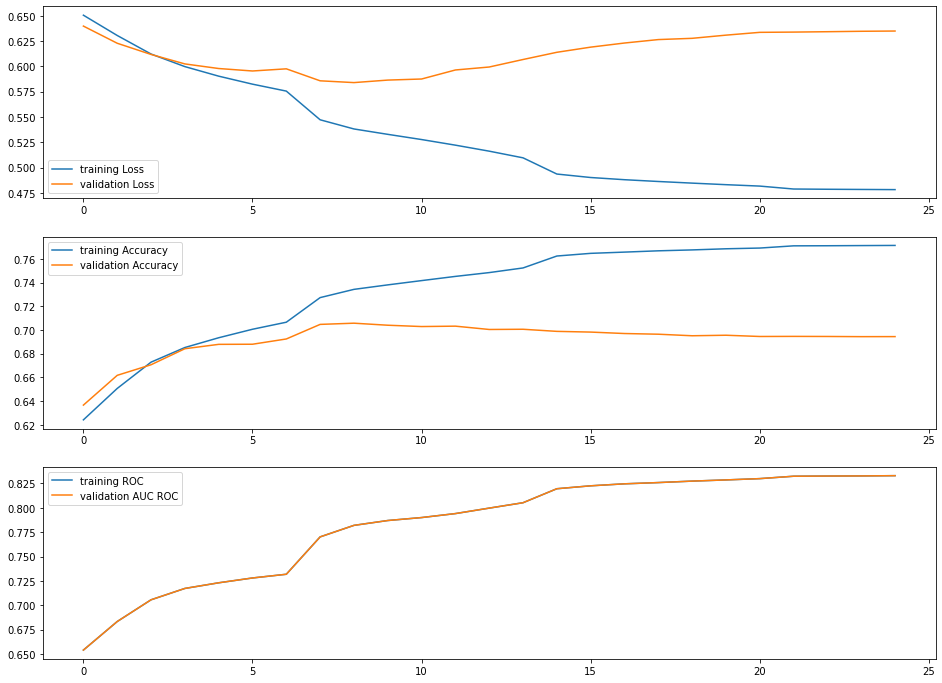

In [ ]:
plotResults(results)

# Basic CN

In [ ]:
class basicCNN(nn.Module):
    def __init__(self):
        super(basicCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(2, 64, 3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Dropout(0.25),

            nn.Conv2d(64, 64, 3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),

            nn.Conv2d(64, 64, 3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Flatten(),
            nn.Linear(1024, 64),
            nn.ReLU(),
            nn.Linear(64, 2),
            nn.Softmax(1)
        )

    def forward(self, x):
        logits = self.model(x)
        return logits


model_ft = basicCNN()
model_ft = model_ft.to(device)

summary(model_ft, input_size=(2, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,216
              ReLU-2           [-1, 64, 32, 32]               0
         MaxPool2d-3           [-1, 64, 16, 16]               0
           Dropout-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          36,928
              ReLU-6           [-1, 64, 16, 16]               0
         MaxPool2d-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,928
              ReLU-9             [-1, 64, 8, 8]               0
        MaxPool2d-10             [-1, 64, 4, 4]               0
          Flatten-11                 [-1, 1024]               0
           Linear-12                   [-1, 64]          65,600
             ReLU-13                   [-1, 64]               0
           Linear-14                   

## Training

In [ ]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters())

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

results = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,{"train" : train_dataloader, "val": validation_dataloader},
                       {"train" : len(training_data), "val" : len(validation_data)}, saveTo="basicNN", num_epochs=50)

Epoch 0/49
----------
train Loss: 0.6428 Acc: 0.6340 AUC ROC : 0.6792 Time taken : 35.54
val Loss: 0.6138 Acc: 0.6782 AUC ROC : 0.7268 Time taken : 4.59

Epoch 1/49
----------
train Loss: 0.6093 Acc: 0.6816 AUC ROC : 0.7338 Time taken : 34.98
val Loss: 0.5949 Acc: 0.7003 AUC ROC : 0.7550 Time taken : 4.52

Epoch 2/49
----------
train Loss: 0.5984 Acc: 0.6948 AUC ROC : 0.7487 Time taken : 34.83
val Loss: 0.5888 Acc: 0.7057 AUC ROC : 0.7616 Time taken : 4.55

Epoch 3/49
----------
train Loss: 0.5941 Acc: 0.6998 AUC ROC : 0.7546 Time taken : 35.11
val Loss: 0.5859 Acc: 0.7095 AUC ROC : 0.7656 Time taken : 4.57

Epoch 4/49
----------
train Loss: 0.5918 Acc: 0.7027 AUC ROC : 0.7577 Time taken : 35.08
val Loss: 0.5863 Acc: 0.7102 AUC ROC : 0.7654 Time taken : 4.52

Epoch 5/49
----------
train Loss: 0.5898 Acc: 0.7050 AUC ROC : 0.7608 Time taken : 35.2
val Loss: 0.5833 Acc: 0.7115 AUC ROC : 0.7713 Time taken : 4.57

Epoch 6/49
----------
train Loss: 0.5880 Acc: 0.7075 AUC ROC : 0.7634 Time ta

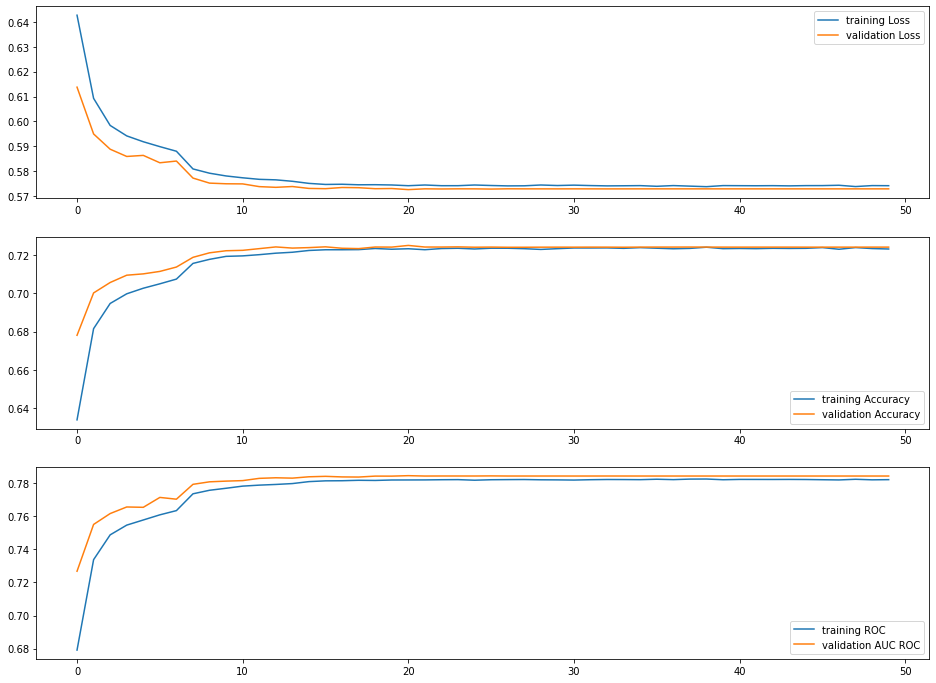

In [ ]:
plotResults(results)

# OK performance classical methods

In [ ]:
class BasicNN(nn.Module):
    def __init__(self):
        super(BasicNN, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2* 32 * 32, 256),
            MaxoutMLP(256, 5, 256),
            nn.Dropout(0.25),
            nn.BatchNorm1d(256),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(64, 2),
            nn.Softmax(1)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


model_ft = BasicNN()
model_ft = model_ft.to(device)

summary(model_ft, input_size=(32,32, 2))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 2048]               0
            Linear-2                  [-1, 256]         524,544
         MaxoutMLP-3                  [-1, 256]               0
           Dropout-4                  [-1, 256]               0
       BatchNorm1d-5                  [-1, 256]             512
            Linear-6                   [-1, 64]          16,448
              ReLU-7                   [-1, 64]               0
           Dropout-8                   [-1, 64]               0
            Linear-9                    [-1, 2]             130
          Softmax-10                    [-1, 2]               0
Total params: 541,634
Trainable params: 541,634
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.02
Params size (MB): 2.07
Estimated T

# Training

In [ ]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters())

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

results = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,{"train" : train_dataloader, "val": validation_dataloader},
                       {"train" : len(training_data), "val" : len(validation_data)}, saveTo="basicNN", num_epochs=50)

Epoch 0/49
----------
train Loss: 0.6518 Acc: 0.6239 AUC ROC : 0.6620 Time taken : 42.48
val Loss: 0.6424 Acc: 0.6353 AUC ROC : 0.6809 Time taken : 4.61

Epoch 1/49
----------
train Loss: 0.6322 Acc: 0.6513 AUC ROC : 0.6985 Time taken : 42.37
val Loss: 0.6252 Acc: 0.6602 AUC ROC : 0.7135 Time taken : 4.62

Epoch 2/49
----------
train Loss: 0.6157 Acc: 0.6732 AUC ROC : 0.7238 Time taken : 42.6
val Loss: 0.6119 Acc: 0.6788 AUC ROC : 0.7298 Time taken : 4.58

Epoch 3/49
----------
train Loss: 0.6055 Acc: 0.6861 AUC ROC : 0.7382 Time taken : 42.25
val Loss: 0.6045 Acc: 0.6874 AUC ROC : 0.7394 Time taken : 4.59

Epoch 4/49
----------
train Loss: 0.5990 Acc: 0.6942 AUC ROC : 0.7470 Time taken : 42.37
val Loss: 0.6010 Acc: 0.6923 AUC ROC : 0.7443 Time taken : 4.57

Epoch 5/49
----------
train Loss: 0.5943 Acc: 0.7004 AUC ROC : 0.7533 Time taken : 42.45
val Loss: 0.6002 Acc: 0.6919 AUC ROC : 0.7456 Time taken : 4.59

Epoch 6/49
----------
train Loss: 0.5908 Acc: 0.7036 AUC ROC : 0.7579 Time ta

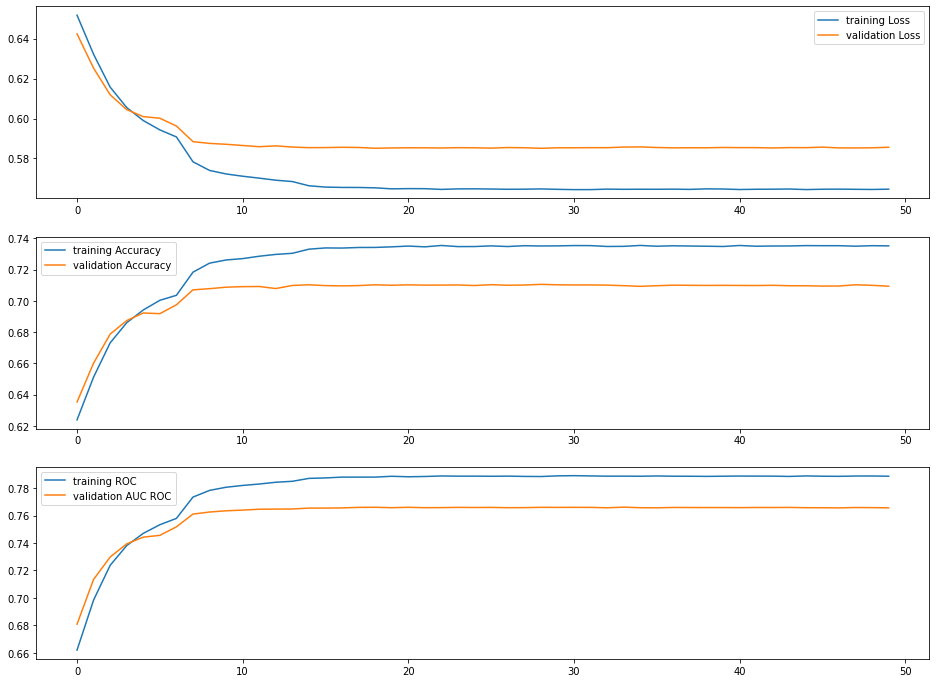

In [ ]:
plotResults(results)

# Vision Transformer

In [ ]:

ViTModel = ViT(
    image_size = 32,
    patch_size = 8,
    num_classes = 2,
    dim = 64,
    depth = 1,
    heads = 4,
    channels=2,
    mlp_dim = 128,
    dropout = 0.1,
    emb_dropout = 0.1
)

ViTModel = ViTModel.to(device)
summary(ViTModel, input_size=(2, 32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Rearrange-1              [-1, 16, 128]               0
            Linear-2               [-1, 16, 64]           8,256
           Dropout-3               [-1, 17, 64]               0
         LayerNorm-4               [-1, 17, 64]             128
            Linear-5              [-1, 17, 768]          49,152
           Softmax-6            [-1, 4, 17, 17]               0
           Dropout-7            [-1, 4, 17, 17]               0
            Linear-8               [-1, 17, 64]          16,448
           Dropout-9               [-1, 17, 64]               0
        Attention-10               [-1, 17, 64]               0
          PreNorm-11               [-1, 17, 64]               0
        LayerNorm-12               [-1, 17, 64]             128
           Linear-13              [-1, 17, 128]           8,320
             GELU-14              [-1, 

# Training

In [ ]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(ViTModel.parameters())

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

results = train_model(ViTModel, criterion, optimizer_ft, exp_lr_scheduler,{"train" : train_dataloader, "val": validation_dataloader},
                       {"train" : len(training_data), "val" : len(validation_data)}, saveTo="basicNN", num_epochs=50)

Epoch 0/49
----------
train Loss: 0.6229 Acc: 0.6582 AUC ROC : 0.7026 Time taken : 38.58
val Loss: 0.5996 Acc: 0.6842 AUC ROC : 0.7387 Time taken : 4.44

Epoch 1/49
----------
train Loss: 0.6073 Acc: 0.6756 AUC ROC : 0.7262 Time taken : 40.38
val Loss: 0.5954 Acc: 0.6876 AUC ROC : 0.7409 Time taken : 4.53

Epoch 2/49
----------
train Loss: 0.6016 Acc: 0.6819 AUC ROC : 0.7336 Time taken : 38.16
val Loss: 0.5959 Acc: 0.6893 AUC ROC : 0.7453 Time taken : 4.46

Epoch 3/49
----------
train Loss: 0.5971 Acc: 0.6865 AUC ROC : 0.7402 Time taken : 38.19
val Loss: 0.5878 Acc: 0.6943 AUC ROC : 0.7529 Time taken : 4.52

Epoch 4/49
----------
train Loss: 0.5955 Acc: 0.6876 AUC ROC : 0.7423 Time taken : 38.18
val Loss: 0.5848 Acc: 0.6976 AUC ROC : 0.7550 Time taken : 4.43

Epoch 5/49
----------
train Loss: 0.5939 Acc: 0.6896 AUC ROC : 0.7439 Time taken : 38.17
val Loss: 0.5956 Acc: 0.6865 AUC ROC : 0.7577 Time taken : 4.45

Epoch 6/49
----------
train Loss: 0.5919 Acc: 0.6912 AUC ROC : 0.7465 Time t

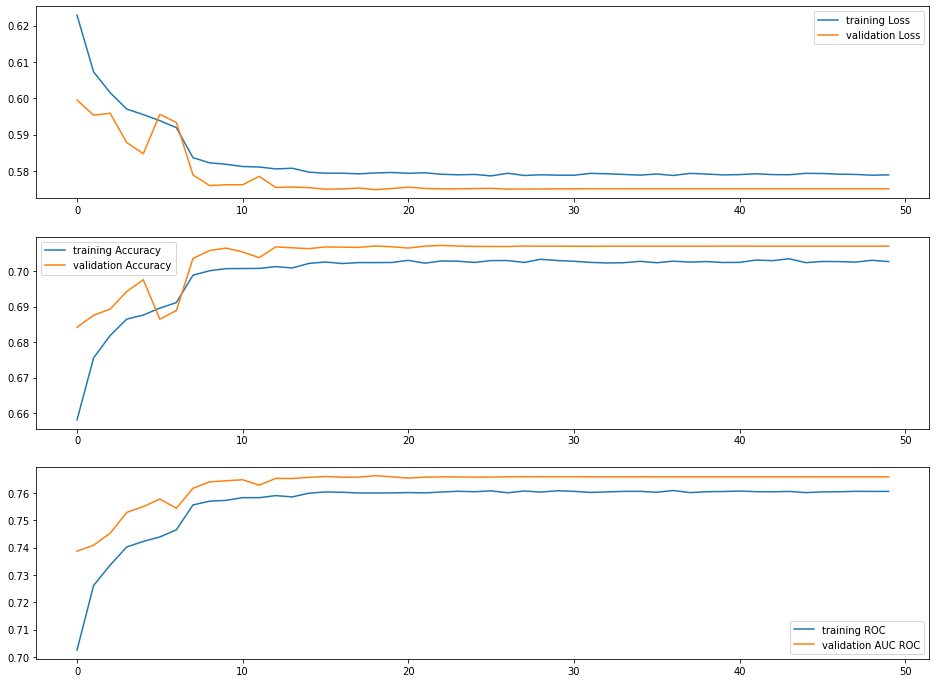

In [ ]:
plotResults(results)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Rearrange-1              [-1, 16, 128]               0
            Linear-2               [-1, 16, 64]           8,256
           Dropout-3               [-1, 17, 64]               0
         LayerNorm-4               [-1, 17, 64]             128
            Linear-5              [-1, 17, 768]          49,152
           Softmax-6            [-1, 4, 17, 17]               0
           Dropout-7            [-1, 4, 17, 17]               0
            Linear-8               [-1, 17, 64]          16,448
           Dropout-9               [-1, 17, 64]               0
        Attention-10               [-1, 17, 64]               0
          PreNorm-11               [-1, 17, 64]               0
        LayerNorm-12               [-1, 17, 64]             128
           Linear-13              [-1, 17, 256]          16,640
             GELU-14              [-1, 

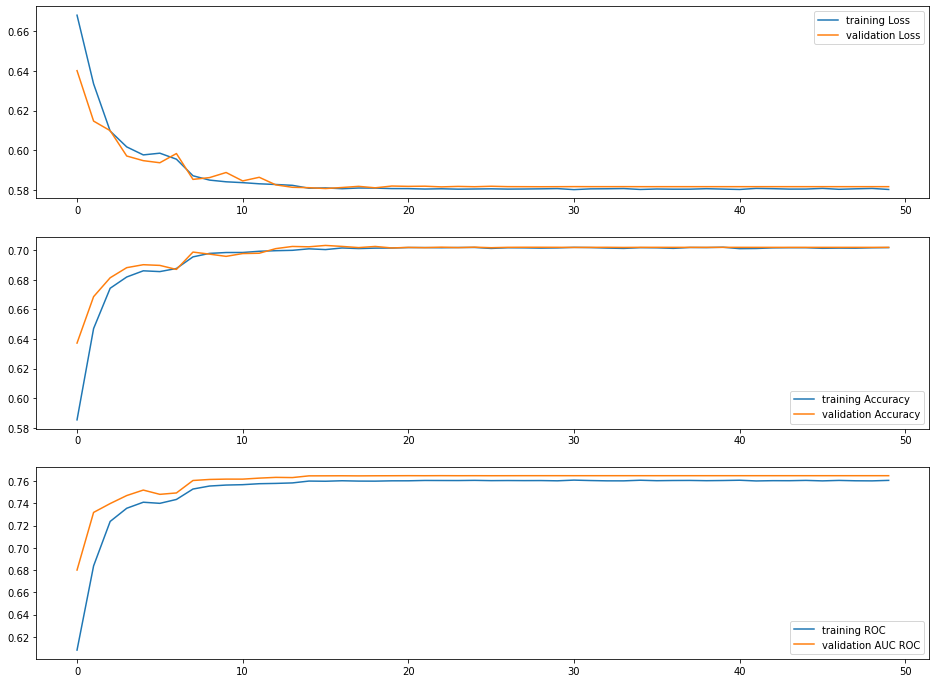

In [ ]:

ViTModel = ViT(
    image_size = 32,
    patch_size = 8,
    num_classes = 2,
    dim = 64,
    depth = 3,
    heads = 4,
    channels=2,
    mlp_dim = 256,
    dropout = 0.2,
    emb_dropout = 0.15
)

ViTModel = ViTModel.to(device)
print(summary(ViTModel, input_size=(2, 32,32)))

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(ViTModel.parameters())

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

results = train_model(ViTModel, criterion, optimizer_ft, exp_lr_scheduler,{"train" : train_dataloader, "val": validation_dataloader},
                       {"train" : len(training_data), "val" : len(validation_data)}, saveTo="basicNN", num_epochs=50)

plotResults(results)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Rearrange-1            [-1, 4, 4, 128]               0
            Linear-2             [-1, 4, 4, 64]           8,256
         LayerNorm-3               [-1, 16, 64]             128
            Linear-4              [-1, 16, 768]          49,152
           Softmax-5            [-1, 4, 16, 16]               0
            Linear-6               [-1, 16, 64]          16,384
         Attention-7               [-1, 16, 64]               0
         LayerNorm-8               [-1, 16, 64]             128
            Linear-9              [-1, 16, 256]          16,640
             GELU-10              [-1, 16, 256]               0
           Linear-11               [-1, 16, 64]          16,448
      FeedForward-12               [-1, 16, 64]               0
      Transformer-13               [-1, 16, 64]               0
         Identity-14                   

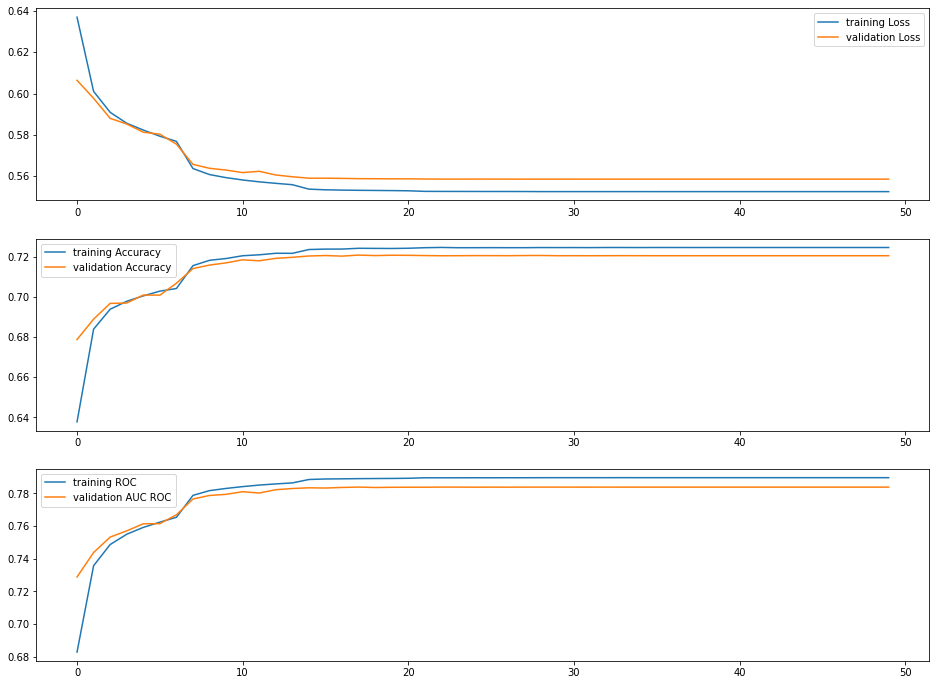

In [ ]:
from vit_pytorch.simple_vit import SimpleViT

ViTModel = SimpleViT(
    image_size = 32,
    patch_size = 8,
    num_classes = 2,
    dim = 64,
    depth = 1,
    heads = 4,
    channels=2,
    mlp_dim = 256
)

ViTModel = ViTModel.to(device)
print(summary(ViTModel, input_size=(2, 32,32)))

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(ViTModel.parameters())

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

results = train_model(ViTModel, criterion, optimizer_ft, exp_lr_scheduler,{"train" : train_dataloader, "val": validation_dataloader},
                       {"train" : len(training_data), "val" : len(validation_data)}, saveTo="basicNN", num_epochs=50)

plotResults(results)

In [ ]:
from vit_pytorch.simple_vit import MobileViT

ViTModel = MobileViT(
    image_size = 32,
    dims = [96, 120, 144],
    channels = [16, 32, 48, 48, 64, 64, 80, 80, 96, 96, 384],
    num_classes = 1000

)

ViTModel = ViTModel.to(device)
print(summary(ViTModel, input_size=(2, 32,32)))

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(ViTModel.parameters())

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

results = train_model(ViTModel, criterion, optimizer_ft, exp_lr_scheduler,{"train" : train_dataloader, "val": validation_dataloader},
                       {"train" : len(training_data), "val" : len(validation_data)}, saveTo="basicNN", num_epochs=50)

plotResults(results)

In [ ]:
class BasicNN(nn.Module):
    def __init__(self):
        super(BasicNN, self).__init__()
        self.flatten1 = nn.Flatten()
        self.left = nn.Sequential(
            nn.Linear(32 * 32, 128),
            MaxoutMLP(128, 3, 128),
            nn.Dropout(0.25),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            MaxoutMLP(64, 3, 64),
            nn.Dropout(0.25),
        )
        self.flatten2 = nn.Flatten()
        self.right = nn.Sequential(
            nn.Linear(32 * 32, 128),
            MaxoutMLP(128, 3, 128),
            nn.Dropout(0.25),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            MaxoutMLP(64, 3, 64),
            nn.Dropout(0.25),
        )

        self.pred = nn.Sequential(
            nn.Linear(128, 2),
            nn.Softmax(1)
        )

    def forward(self, x):
        x1 = self.flatten1(x[:, 0, :, :])
        y1 = self.left(x1)

        x2 = self.flatten1(x[:, 1, :, :])
        y2 = self.right(x2)

        y3 = torch.cat([y1, y2], axis=1)

        return self.pred(y3)


model_ft = BasicNN()
model_ft = model_ft.to(device)

print(summary(model_ft, input_size=(2, 32,32)))

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters())

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

results = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,{"train" : train_dataloader, "val": validation_dataloader},
                       {"train" : len(training_data), "val" : len(validation_data)}, saveTo="basicNN", num_epochs=50)

plotResults(results)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 1024]               0
       BatchNorm1d-2                 [-1, 1024]           2,048
            Linear-3                  [-1, 128]         131,200
         MaxoutMLP-4                  [-1, 128]               0
           Dropout-5                  [-1, 128]               0
       BatchNorm1d-6                  [-1, 128]             256
            Linear-7                   [-1, 64]           8,256
         MaxoutMLP-8                   [-1, 64]               0
           Dropout-9                   [-1, 64]               0
          Flatten-10                 [-1, 1024]               0
      BatchNorm1d-11                 [-1, 1024]           2,048
           Linear-12                  [-1, 128]         131,200
        MaxoutMLP-13                  [-1, 128]               0
          Dropout-14                  [

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             160
              ReLU-2           [-1, 16, 32, 32]               0
         MaxPool2d-3           [-1, 16, 16, 16]               0
           Dropout-4           [-1, 16, 16, 16]               0
            Conv2d-5           [-1, 16, 16, 16]           2,320
              ReLU-6           [-1, 16, 16, 16]               0
         MaxPool2d-7             [-1, 16, 8, 8]               0
            Conv2d-8             [-1, 16, 8, 8]           2,320
              ReLU-9             [-1, 16, 8, 8]               0
        MaxPool2d-10             [-1, 16, 4, 4]               0
          Flatten-11                  [-1, 256]               0
           Linear-12                   [-1, 64]          16,448
    BasicCNNBlock-13                   [-1, 64]               0
           Conv2d-14           [-1, 16,

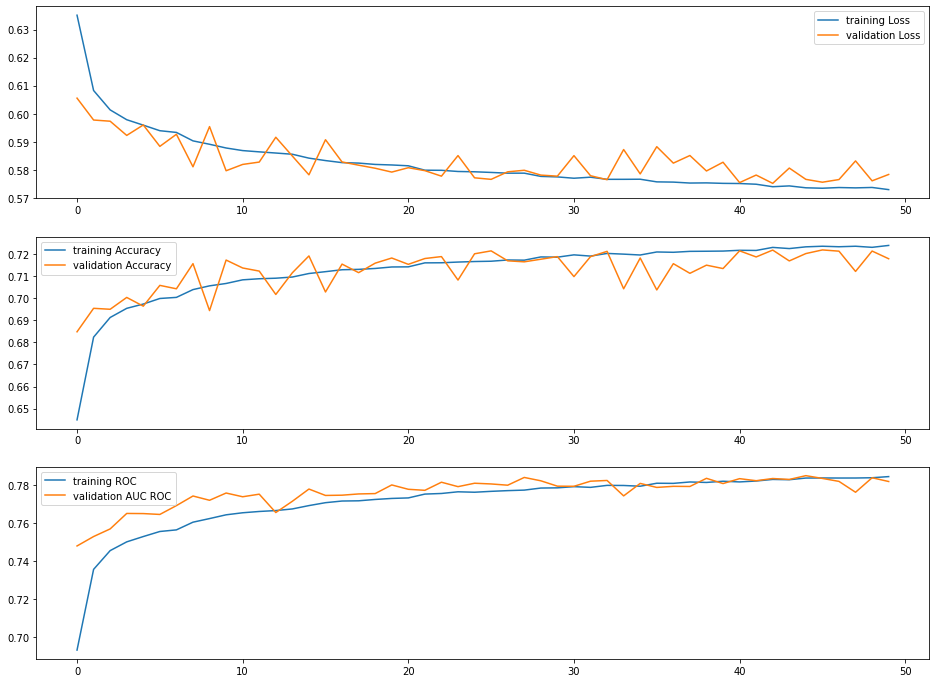

In [ ]:

class BasicCNNBlock(nn.Module):
    def __init__(self):
        super(BasicCNNBlock, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Dropout(0.25),

            nn.Conv2d(16, 16, 3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),

            nn.Conv2d(16, 16, 3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Flatten(),
            nn.Linear(256, 64),
        )

    def forward(self, x):
        logits = self.model(x)
        return logits


class splittedCNN(nn.Module):
    def __init__(self):
        super(splittedCNN, self).__init__()

        self.cnn1 = BasicCNNBlock()
        self.cnn2 = BasicCNNBlock()

        self.pred = nn.Sequential(
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,2),
            nn.Softmax(1)
        )

    def forward(self, x):

        y1 = self.cnn1(x[:, 0, :, :].reshape(-1, 1, 32, 32))
        y2 = self.cnn2(x[:, 1, :, :].reshape(-1, 1, 32, 32))
        y3 = torch.cat([y1, y2], axis=1)
        return self.pred(y3)


model = splittedCNN()
model = model.to(device)

print(summary(model, input_size=(2, 32, 32)))

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters())

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.8)

results = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,{"train" : train_dataloader, "val": validation_dataloader},
                       {"train" : len(training_data), "val" : len(validation_data)}, saveTo="basicNN", num_epochs=50)

plotResults(results)


In [ ]:
import torch
import torch.nn as nn

from einops import rearrange
from einops.layers.torch import Reduce

# helpers

def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.SiLU()
    )

def conv_nxn_bn(inp, oup, kernal_size=3, stride=1):
    return nn.Sequential(
        nn.Conv2d(inp, oup, kernal_size, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.SiLU()
    )

# classes

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(
            t, 'b p n (h d) -> b p h n d', h=self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b p h n d -> b p n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    """Transformer block described in ViT.
    Paper: https://arxiv.org/abs/2010.11929
    Based on: https://github.com/lucidrains/vit-pytorch
    """

    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout=0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads, dim_head, dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout))
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class MV2Block(nn.Module):
    """MV2 block described in MobileNetV2.
    Paper: https://arxiv.org/pdf/1801.04381
    Based on: https://github.com/tonylins/pytorch-mobilenet-v2
    """

    def __init__(self, inp, oup, stride=1, expansion=4):
        super().__init__()
        self.stride = stride
        assert stride in [1, 2]

        hidden_dim = int(inp * expansion)
        self.use_res_connect = self.stride == 1 and inp == oup

        if expansion == 1:
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride,
                          1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.SiLU(),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.SiLU(),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride,
                          1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.SiLU(),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )

    def forward(self, x):
        out = self.conv(x)
        if self.use_res_connect:
            out = out + x
        return out

class MobileViTBlock(nn.Module):
    def __init__(self, dim, depth, channel, kernel_size, patch_size, mlp_dim, dropout=0.):
        super().__init__()
        self.ph, self.pw = patch_size

        self.conv1 = conv_nxn_bn(channel, channel, kernel_size)
        self.conv2 = conv_1x1_bn(channel, dim)

        self.transformer = Transformer(dim, depth, 4, 8, mlp_dim, dropout)

        self.conv3 = conv_1x1_bn(dim, channel)
        self.conv4 = conv_nxn_bn(2 * channel, channel, kernel_size)

    def forward(self, x):
        y = x.clone()

        # Local representations
        x = self.conv1(x)
        x = self.conv2(x)

        # Global representations
        _, _, h, w = x.shape
        x = rearrange(x, 'b d (h ph) (w pw) -> b (ph pw) (h w) d',
                      ph=self.ph, pw=self.pw)
        x = self.transformer(x)
        x = rearrange(x, 'b (ph pw) (h w) d -> b d (h ph) (w pw)',
                      h=h//self.ph, w=w//self.pw, ph=self.ph, pw=self.pw)

        # Fusion
        x = self.conv3(x)
        x = torch.cat((x, y), 1)
        x = self.conv4(x)
        return x

class MobileViT(nn.Module):
    """MobileViT.
    Paper: https://arxiv.org/abs/2110.02178
    Based on: https://github.com/chinhsuanwu/mobilevit-pytorch
    """

    def __init__(
        self,
        image_size,
        dims,
        channels,
        num_classes,
        expansion=4,
        kernel_size=3,
        patch_size=(2, 2),
        depths=(2, 4, 3)
    ):
        super().__init__()
        assert len(dims) == 3, 'dims must be a tuple of 3'
        assert len(depths) == 3, 'depths must be a tuple of 3'

        ih, iw = image_size
        ph, pw = patch_size
        assert ih % ph == 0 and iw % pw == 0

        init_dim, *_, last_dim = channels

        self.conv1 = conv_nxn_bn(2, init_dim, stride=2)

        self.stem = nn.ModuleList([])
        self.stem.append(MV2Block(channels[0], channels[1], 1, expansion))
        self.stem.append(MV2Block(channels[1], channels[2], 2, expansion))
        self.stem.append(MV2Block(channels[2], channels[3], 1, expansion))
        self.stem.append(MV2Block(channels[2], channels[3], 1, expansion))

        self.trunk = nn.ModuleList([])
        self.trunk.append(nn.ModuleList([
            MV2Block(channels[3], channels[4], 2, expansion),
            MobileViTBlock(dims[0], depths[0], channels[5],
                           kernel_size, patch_size, int(dims[0] * 2))
        ]))

        '''
        self.trunk.append(nn.ModuleList([
            MV2Block(channels[5], channels[6], 2, expansion),
            MobileViTBlock(dims[1], depths[1], channels[7],
                           kernel_size, patch_size, int(dims[1] * 4))
        ]))

        self.trunk.append(nn.ModuleList([
            MV2Block(channels[7], channels[8], 2, expansion),
            MobileViTBlock(dims[2], depths[2], channels[9],
                           kernel_size, patch_size, int(dims[2] * 4))
        ]))
        '''

        self.to_logits = nn.Sequential(
            conv_1x1_bn(channels[-2], last_dim),
            Reduce('b c h w -> b c', 'mean'),
            nn.Linear(channels[-1], num_classes, bias=False)
        )

    def forward(self, x):
        x = self.conv1(x)

        for conv in self.stem:
            x = conv(x)

        for conv, attn in self.trunk:
            x = conv(x)
            x = attn(x)

        return self.to_logits(x)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 16, 16]             288
       BatchNorm2d-2           [-1, 16, 16, 16]              32
              SiLU-3           [-1, 16, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]           1,024
       BatchNorm2d-5           [-1, 64, 16, 16]             128
              SiLU-6           [-1, 64, 16, 16]               0
            Conv2d-7           [-1, 64, 16, 16]             576
       BatchNorm2d-8           [-1, 64, 16, 16]             128
              SiLU-9           [-1, 64, 16, 16]               0
           Conv2d-10           [-1, 32, 16, 16]           2,048
      BatchNorm2d-11           [-1, 32, 16, 16]              64
         MV2Block-12           [-1, 32, 16, 16]               0
           Conv2d-13          [-1, 128, 16, 16]           4,096
      BatchNorm2d-14          [-1, 128,

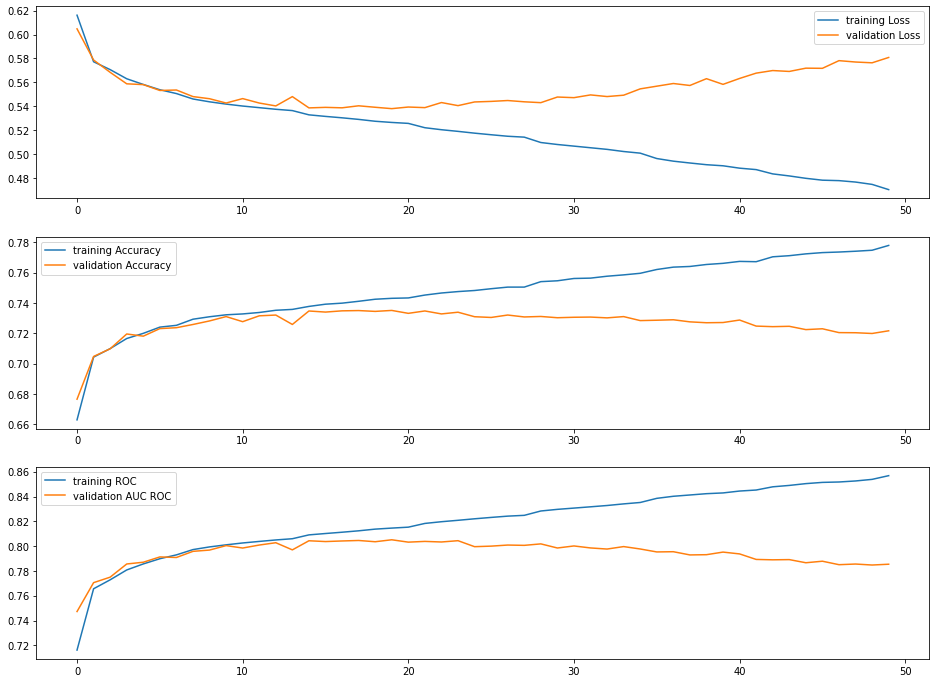

In [ ]:

model = MobileViT(image_size = (32, 32),
    dims = [96, 120, 144],
    channels = [16, 32, 48, 48, 96, 96],
    num_classes = 2)
model = model.to(device)

print(summary(model, input_size=(2, 32, 32)))

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters())

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.8)

results = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,{"train" : train_dataloader, "val": validation_dataloader},
                       {"train" : len(training_data), "val" : len(validation_data)}, saveTo="basicNN", num_epochs=50)

plotResults(results)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 16, 16]             288
       BatchNorm2d-2           [-1, 16, 16, 16]              32
              SiLU-3           [-1, 16, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]           1,024
       BatchNorm2d-5           [-1, 64, 16, 16]             128
              SiLU-6           [-1, 64, 16, 16]               0
            Conv2d-7           [-1, 64, 16, 16]             576
       BatchNorm2d-8           [-1, 64, 16, 16]             128
              SiLU-9           [-1, 64, 16, 16]               0
           Conv2d-10           [-1, 32, 16, 16]           2,048
      BatchNorm2d-11           [-1, 32, 16, 16]              64
         MV2Block-12           [-1, 32, 16, 16]               0
           Conv2d-13          [-1, 128, 16, 16]           4,096
      BatchNorm2d-14          [-1, 128,

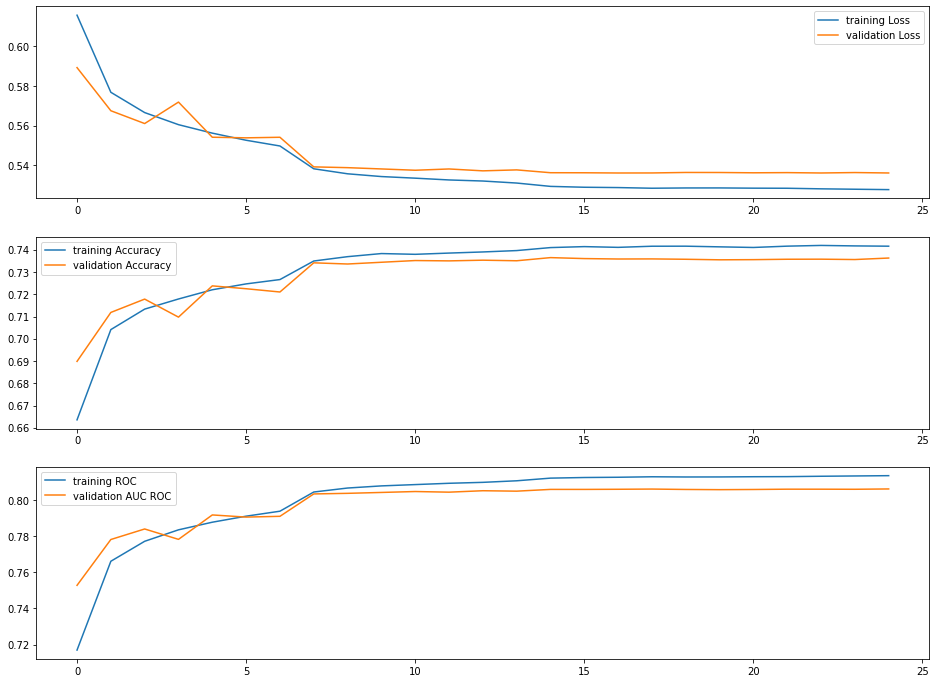

In [ ]:
import torch
import torch.nn as nn

from einops import rearrange
from einops.layers.torch import Reduce

# helpers

def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.SiLU()
    )

def conv_nxn_bn(inp, oup, kernal_size=3, stride=1):
    return nn.Sequential(
        nn.Conv2d(inp, oup, kernal_size, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.SiLU()
    )

# classes

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(
            t, 'b p n (h d) -> b p h n d', h=self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b p h n d -> b p n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    """Transformer block described in ViT.
    Paper: https://arxiv.org/abs/2010.11929
    Based on: https://github.com/lucidrains/vit-pytorch
    """

    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout=0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads, dim_head, dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout))
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class MV2Block(nn.Module):
    """MV2 block described in MobileNetV2.
    Paper: https://arxiv.org/pdf/1801.04381
    Based on: https://github.com/tonylins/pytorch-mobilenet-v2
    """

    def __init__(self, inp, oup, stride=1, expansion=4):
        super().__init__()
        self.stride = stride
        assert stride in [1, 2]

        hidden_dim = int(inp * expansion)
        self.use_res_connect = self.stride == 1 and inp == oup

        if expansion == 1:
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride,
                          1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.SiLU(),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.SiLU(),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride,
                          1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.SiLU(),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )

    def forward(self, x):
        out = self.conv(x)
        if self.use_res_connect:
            out = out + x
        return out

class MobileViTBlock(nn.Module):
    def __init__(self, dim, depth, channel, kernel_size, patch_size, mlp_dim, dropout=0.):
        super().__init__()
        self.ph, self.pw = patch_size

        self.conv1 = conv_nxn_bn(channel, channel, kernel_size)
        self.conv2 = conv_1x1_bn(channel, dim)

        self.transformer = Transformer(dim, depth, 4, 8, mlp_dim, dropout)

        self.conv3 = conv_1x1_bn(dim, channel)
        self.conv4 = conv_nxn_bn(2 * channel, channel, kernel_size)

    def forward(self, x):
        y = x.clone()

        # Local representations
        x = self.conv1(x)
        x = self.conv2(x)

        # Global representations
        _, _, h, w = x.shape
        x = rearrange(x, 'b d (h ph) (w pw) -> b (ph pw) (h w) d',
                      ph=self.ph, pw=self.pw)
        x = self.transformer(x)
        x = rearrange(x, 'b (ph pw) (h w) d -> b d (h ph) (w pw)',
                      h=h//self.ph, w=w//self.pw, ph=self.ph, pw=self.pw)

        # Fusion
        x = self.conv3(x)
        x = torch.cat((x, y), 1)
        x = self.conv4(x)
        return x

class MobileViT2(nn.Module):
    """MobileViT.
    Paper: https://arxiv.org/abs/2110.02178
    Based on: https://github.com/chinhsuanwu/mobilevit-pytorch
    """

    def __init__(
        self,
        image_size,
        dims,
        channels,
        num_classes,
        expansion=4,
        kernel_size=3,
        patch_size=(2, 2),
        depths=(2, 4, 3)
    ):
        super().__init__()
        assert len(dims) == 3, 'dims must be a tuple of 3'
        assert len(depths) == 3, 'depths must be a tuple of 3'

        ih, iw = image_size
        ph, pw = patch_size
        assert ih % ph == 0 and iw % pw == 0

        init_dim, *_, last_dim = channels

        self.conv1 = conv_nxn_bn(2, init_dim, stride=2)

        self.stem = nn.ModuleList([])
        self.stem.append(MV2Block(channels[0], channels[1], 1, expansion))
        self.stem.append(MV2Block(channels[1], channels[2], 2, expansion))


        self.trunk = nn.ModuleList([])
        self.trunk.append(nn.ModuleList([
            MV2Block(channels[2], channels[3], 2, expansion),
            MobileViTBlock(dims[0], depths[0], channels[len(channels)-1],
                           kernel_size, patch_size, int(dims[0] * 2))
        ]))

        self.to_logits = nn.Sequential(
            conv_1x1_bn(channels[-2], last_dim),
            Reduce('b c h w -> b c', 'mean'),
            nn.Linear(channels[-1], num_classes, bias=False)
        )

    def forward(self, x):
        x = self.conv1(x)

        for conv in self.stem:
            x = conv(x)

        for conv, attn in self.trunk:
            x = conv(x)
            x = attn(x)

        return self.to_logits(x)




model = MobileViT2(image_size = (32, 32),
    dims = [32, 48, 64],
    channels = [16, 32, 48, 96, 96],
    num_classes = 2)
model = model.to(device)

print(summary(model, input_size=(2, 32, 32)))

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters())

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

results = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,{"train" : train_dataloader, "val": validation_dataloader},
                       {"train" : len(training_data), "val" : len(validation_data)}, saveTo="basicNN", num_epochs=25)

plotResults(results)
